In [1]:
from lenskit.datasets import ML100K
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn

In [2]:
import pandas as pd

In [3]:
%matplotlib inline

In [7]:
ml100k = ML100K('ml-100k')
ratings = ml100k.ratings
ratings.head()

FileNotFoundError: [Errno 2] No such file or directory: 'ml-100k\\u.data'

In [5]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50)

In [6]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [13]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))

In [14]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,1367,4.995519,1,1,ItemItem
1,963,4.957672,1,2,ItemItem
2,408,4.895251,1,3,ItemItem
3,285,4.878812,1,4,ItemItem
4,479,4.805844,1,5,ItemItem


In [15]:
test_data = pd.concat(test_data, ignore_index=True)

In [16]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

nrecs      ndcg
Algorithm user                 
ItemItem  1       100  0.148172
          6       100  0.322083
          8       100  0.034753
          15      100  0.020888
          22      100  0.074859

In [17]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
ALS         0.122847
ItemItem    0.098829
Name: ndcg, dtype: float64

<AxesSubplot:xlabel='Algorithm'>

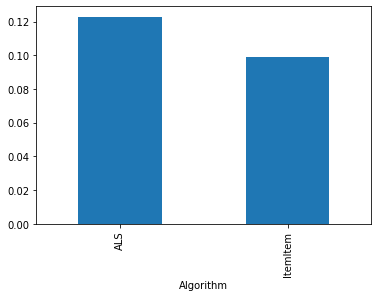

In [18]:
results.groupby('Algorithm').ndcg.mean().plot.bar()